In [ ]:
# setting eviornment
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.2.5

In [ ]:
import os
#installing maskrcnn
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py install


In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import sys
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
from os import listdir
from xml.etree import ElementTree
from PIL import Image
import glob
import cv2
import skimage.transform
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.utils import Dataset

import time

from sklearn.model_selection import train_test_split

import shutil

Using TensorFlow backend.


In [ ]:
os.chdir('/content/drive/MyDrive/Rotated_CNIC')
!ls
os.chdir('/content/Mask_RCNN')

Rotated_Images	Rotated_XMLs


Creating train data directory

In [ ]:
# creating new directory where train images will be stored
dir = os.path.join("/content/Train_Set")
if not os.path.exists(dir):
    os.mkdir(dir)

# now making 2 directories inside train set
dir = os.path.join("/content/Train_Set/Pak_CNIC")
if not os.path.exists(dir):
    os.mkdir(dir)

dir = os.path.join("/content/Train_Set/Pak_Passport")
if not os.path.exists(dir):
    os.mkdir(dir)


Creating test data directory

In [ ]:
# creating new directory where test images will be stored
dir = os.path.join("/content/Test_Set")
if not os.path.exists(dir):
    os.mkdir(dir)

# now making 2 directories inside train set
dir = os.path.join("/content/Test_Set/Pak_CNIC")
if not os.path.exists(dir):
    os.mkdir(dir)

dir = os.path.join("/content/Test_Set/Pak_Passport")
if not os.path.exists(dir):
    os.mkdir(dir)

Setting and Storing Training and Testing Data

In [ ]:
# CNIC Images
cnic_images_path = '/content/drive/MyDrive/Rotated_CNIC/Rotated_Images'
cnic_images = os.listdir(cnic_images_path)
cnic_images_array = np.asarray(cnic_images)

X_train, X_test = train_test_split(cnic_images_array, test_size = 0.2, random_state=42) 

for image in X_train:
  shutil.copy(cnic_images_path + '/' + image, '/content/Train_Set/Pak_CNIC')

for image in X_test:
  shutil.copy(cnic_images_path + '/' + image, '/content/Test_Set/Pak_CNIC')


# Passport Images
passport_images_path = '/content/drive/MyDrive/Rotated_Passport/Rotated_Images'
passport_images = os.listdir(passport_images_path)
passport_images_array = np.asarray(passport_images)

X_train, X_test = train_test_split(passport_images_array, test_size = 0.2, random_state=42) 

for image in X_train:
  shutil.copy(passport_images_path + '/' + image, '/content/Train_Set/Pak_Passport')

for image in X_test:
  shutil.copy(passport_images_path + '/' + image, '/content/Test_Set/Pak_Passport')

In [ ]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"

    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # number of classes (we would normally add +1 for the background)
    # fire name + last name + gender + card no + date of birth + BG
    NUM_CLASSES = 5 + 1

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Learning rate
    LEARNING_RATE = 0.001

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.8

    # setting Max ground truth instances
    MAX_GT_INSTANCES = 10

In [ ]:
# annotation_path = '/imagefolder/'
# rotated_images_path = '/xmlfolder/'


class CardDataset(Dataset):
    
    count = 1

    def adding_images(self, class_name, images_dir, is_train):
      image_count = 0
      for filename in listdir(images_dir):
        # extract image id
        # removing last 4 characters which are always: .jpg
        if('jpg' in filename or 'png' in filename):
          image_id = filename[:-4]

          # if is_train and self.count >= 31:
            
          #   continue

          # if not is_train and self.count < 31:
          #   self.count += 1
          #   continue

          # setting image file
          img_path = images_dir + '/' + filename
          
          # setting annotations file
          ann_path = '/content/drive/MyDrive/' + class_name + '/Rotated_XMLs/' + image_id + '.xml'
          # ann_path = '/content/drive/MyDrive/og_xmls/' + image_id + '.xml'

          # adding images and annotations to dataset
          self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

          self.count += 1
          image_count += 1
      print("No of images in this set = ", image_count)


    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "first name")
        self.add_class("dataset", 2, "last name")
        self.add_class("dataset", 3, "card no")
        self.add_class("dataset", 4, "gender")
        self.add_class("dataset", 5, "date of birth")

        images_dir = dataset_dir + '/Pak_CNIC'
        self.adding_images('Rotated_CNIC', images_dir, is_train)

        images_dir = dataset_dir + '/Pak_Passport'
        self.adding_images('Rotated_Passport', images_dir, is_train)
        
            

    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        class_names = list()


        for class_name in root.findall('.//object'):
          class_names.append(class_name.find('name').text)

        for box in root.findall('.//bndbox'):
            xmin = float(box.find('xmin').text)
            ymin = float(box.find('ymin').text)
            xmax = float(box.find('xmax').text)
            ymax = float(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height, class_names

    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]

        # define annotation  file location
        path = info['annotation']

        # load XML
        boxes, w, h, class_names = self.extract_boxes(path)

        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')

        # create masks
        class_ids = list()
        for i in range(len(boxes)): # 5 boxes for each class
            box = boxes[i]
            row_s, row_e = int(box[1]), int(box[3])
            col_s, col_e = int(box[0]), int(box[2])
            masks[row_s:row_e, col_s:col_e, i] = 1

            class_ids.append(self.class_names.index(class_names[i]))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']





In [ ]:
config = myMaskRCNNConfig()

# prepare train set
train_set = CardDataset()
train_set.load_dataset('/content/Train_Set', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = CardDataset()
test_set.load_dataset('/content/Test_Set', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# i = 0
# for info in train_set.image_info:
#     print(info)
#     i += 1
#     if i>9:
#       break




No of images in this set =  1800
No of images in this set =  1512
Train: 3312
No of images in this set =  451
No of images in this set =  378
Test: 829


In [ ]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training",
                          config=config,
                          model_dir='/content/Mask_RCNN')



# load the weights for COCO
model.load_weights('/content/Mask_RCNN/mask_rcnn_coco.h5',
                   by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])






In [ ]:
# train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=100, layers='heads')


model_path = '/content/Mask_RCNN/new_weights2' + '.h5'
model.keras_model.save_weights(model_path)


In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='/content/Mask_RCNN')

# loading the trained weights o the custom dataset

model.load_weights('/content/drive/MyDrive/new_weights.h5', by_name=True)

{'id': 'pass12_rotation47', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass12_rotation47.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass12_rotation47.xml'}
image ID: dataset.pass12_rotation47 (500) /content/Test_Set/Pak_Passport/pass12_rotation47.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


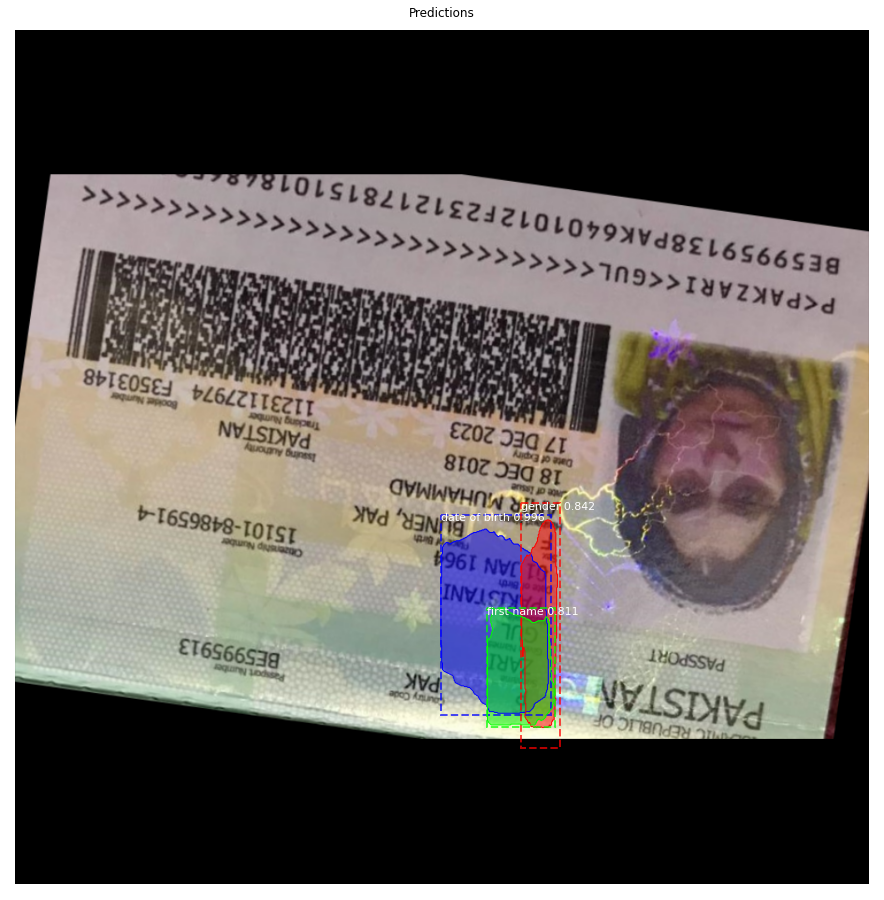

{'id': 'pass2_rotation46', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass2_rotation46.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass2_rotation46.xml'}
image ID: dataset.pass2_rotation46 (501) /content/Test_Set/Pak_Passport/pass2_rotation46.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


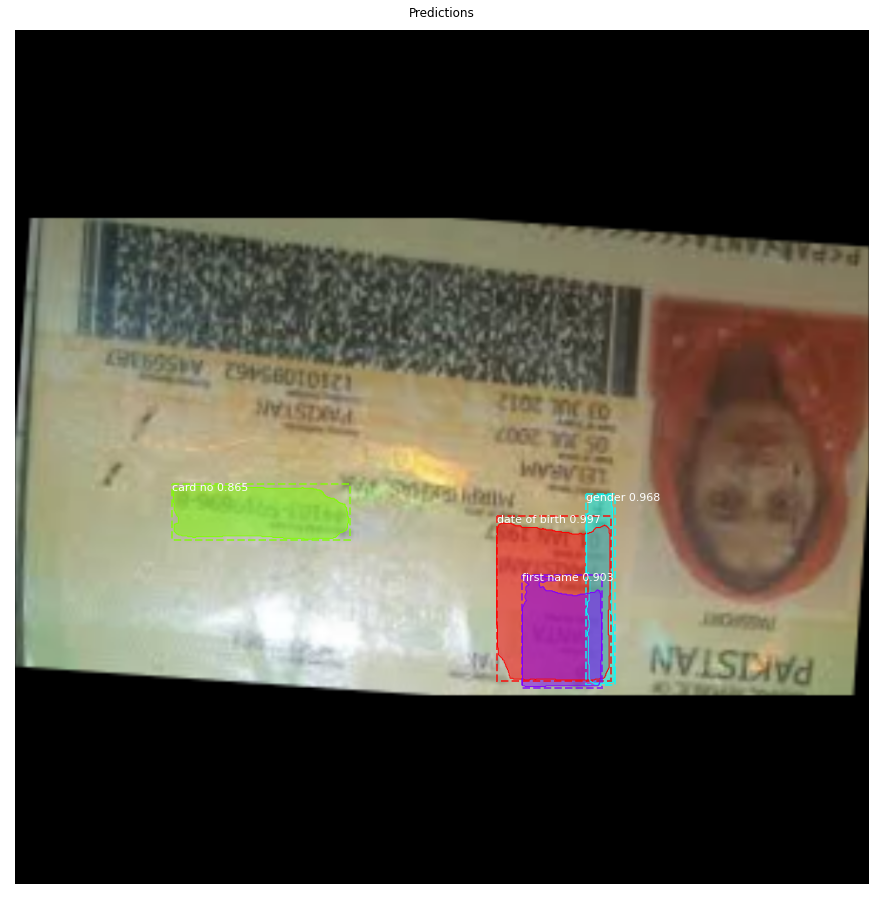

{'id': 'pass18_rotation41', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass18_rotation41.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass18_rotation41.xml'}
image ID: dataset.pass18_rotation41 (502) /content/Test_Set/Pak_Passport/pass18_rotation41.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  233.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  116.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


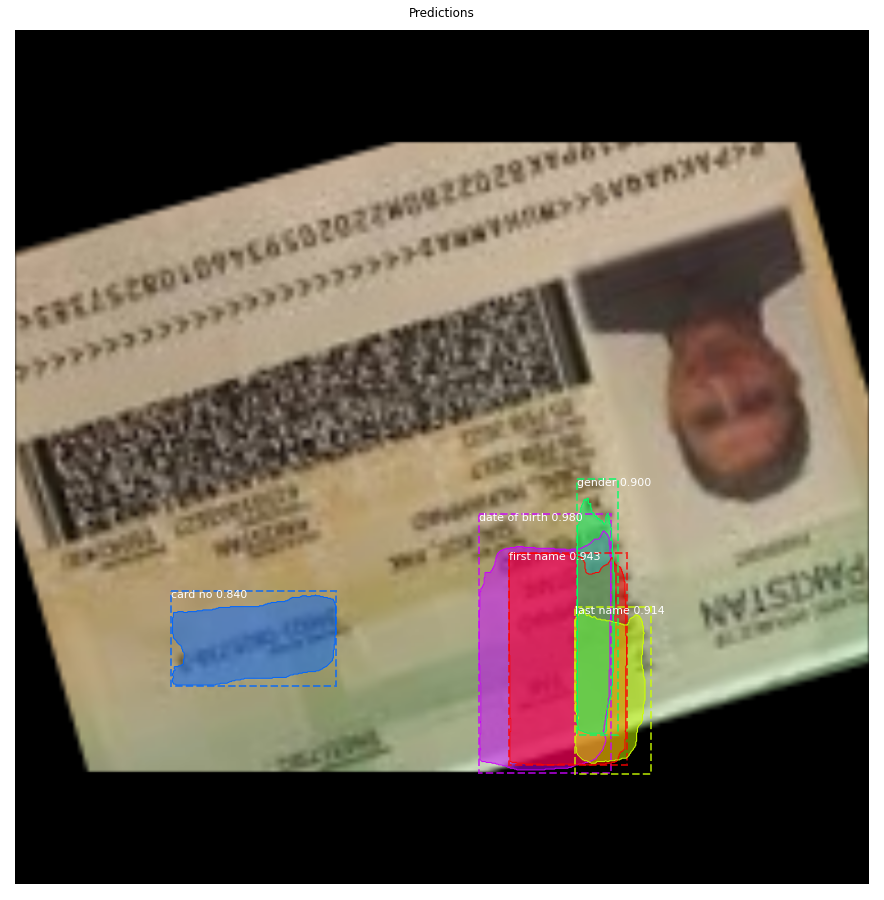

{'id': 'pass3_rotation44', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass3_rotation44.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass3_rotation44.xml'}
image ID: dataset.pass3_rotation44 (503) /content/Test_Set/Pak_Passport/pass3_rotation44.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


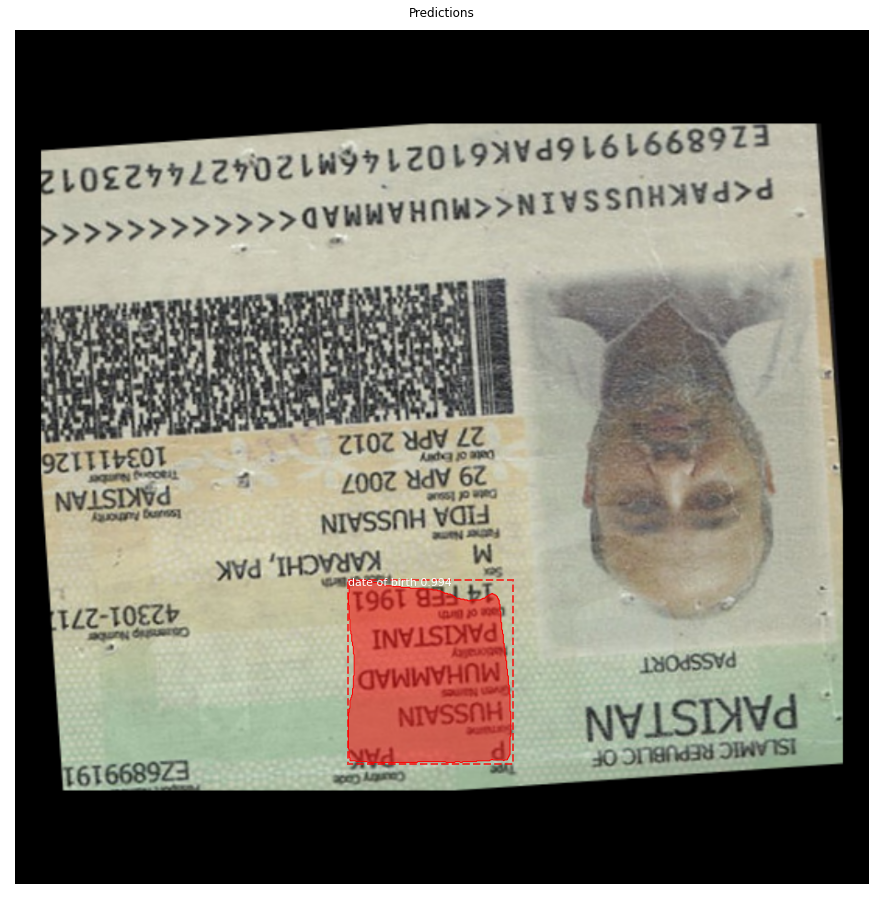

{'id': 'pass11_rotation78', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass11_rotation78.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass11_rotation78.xml'}
image ID: dataset.pass11_rotation78 (504) /content/Test_Set/Pak_Passport/pass11_rotation78.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


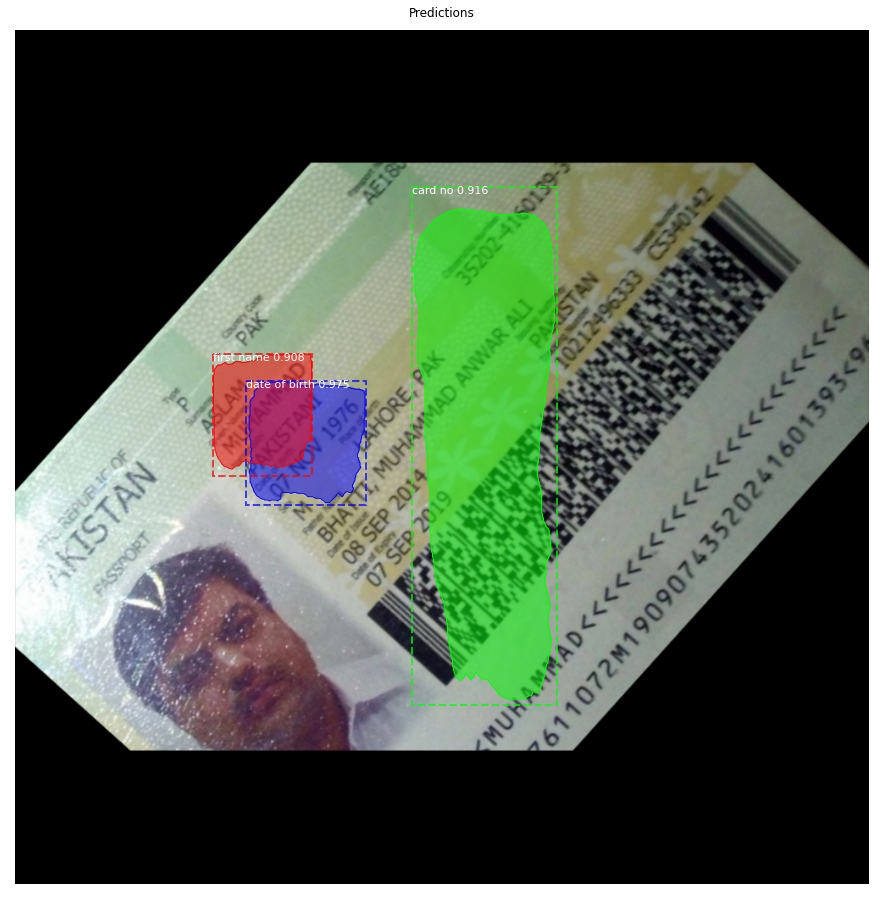

{'id': 'pass2_rotation75', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass2_rotation75.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass2_rotation75.xml'}
image ID: dataset.pass2_rotation75 (505) /content/Test_Set/Pak_Passport/pass2_rotation75.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


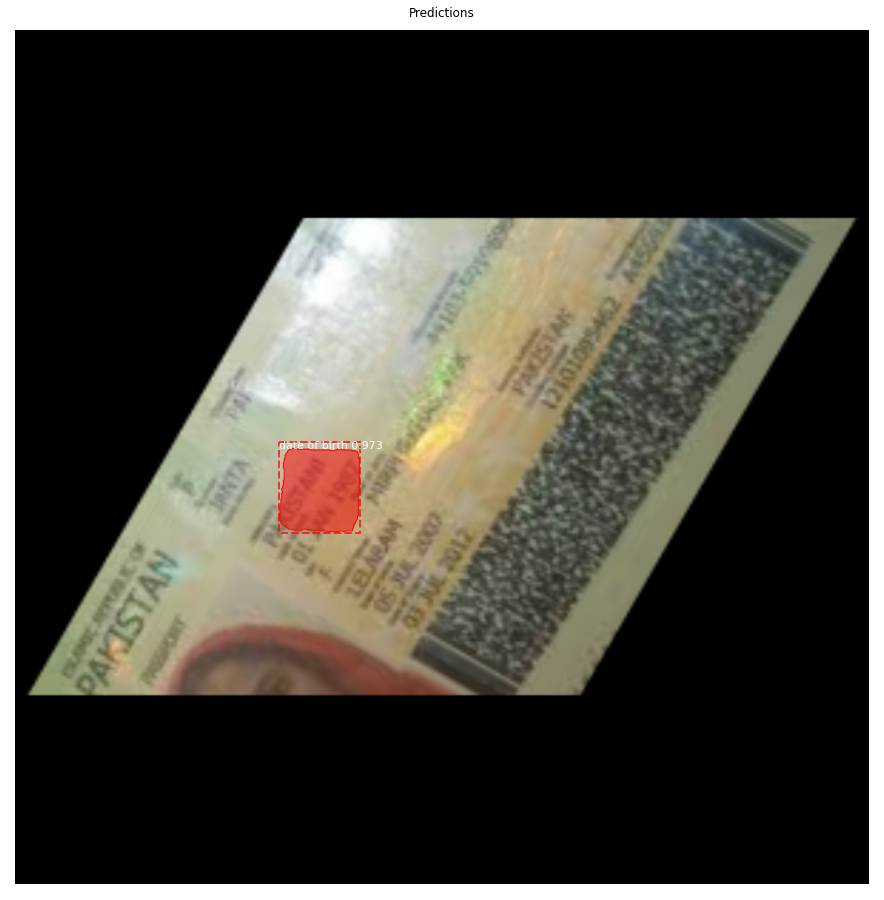

{'id': 'pass10_rotation81', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass10_rotation81.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass10_rotation81.xml'}
image ID: dataset.pass10_rotation81 (506) /content/Test_Set/Pak_Passport/pass10_rotation81.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


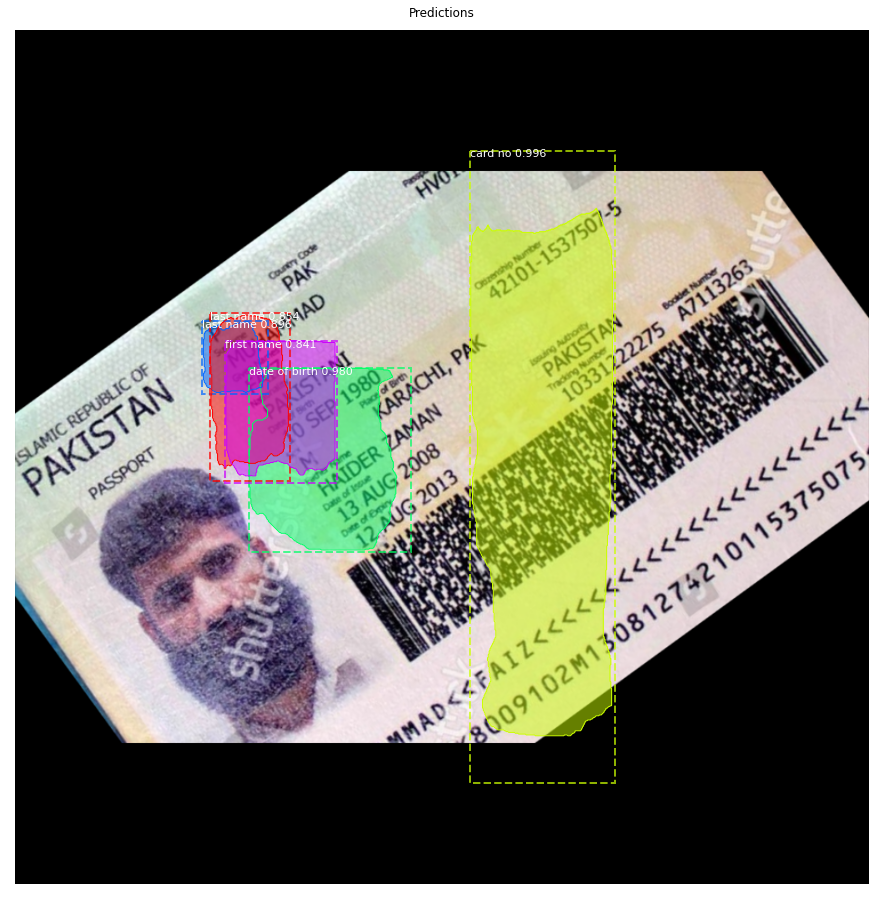

{'id': 'pass3_rotation75', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass3_rotation75.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass3_rotation75.xml'}
image ID: dataset.pass3_rotation75 (507) /content/Test_Set/Pak_Passport/pass3_rotation75.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  247.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  132.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


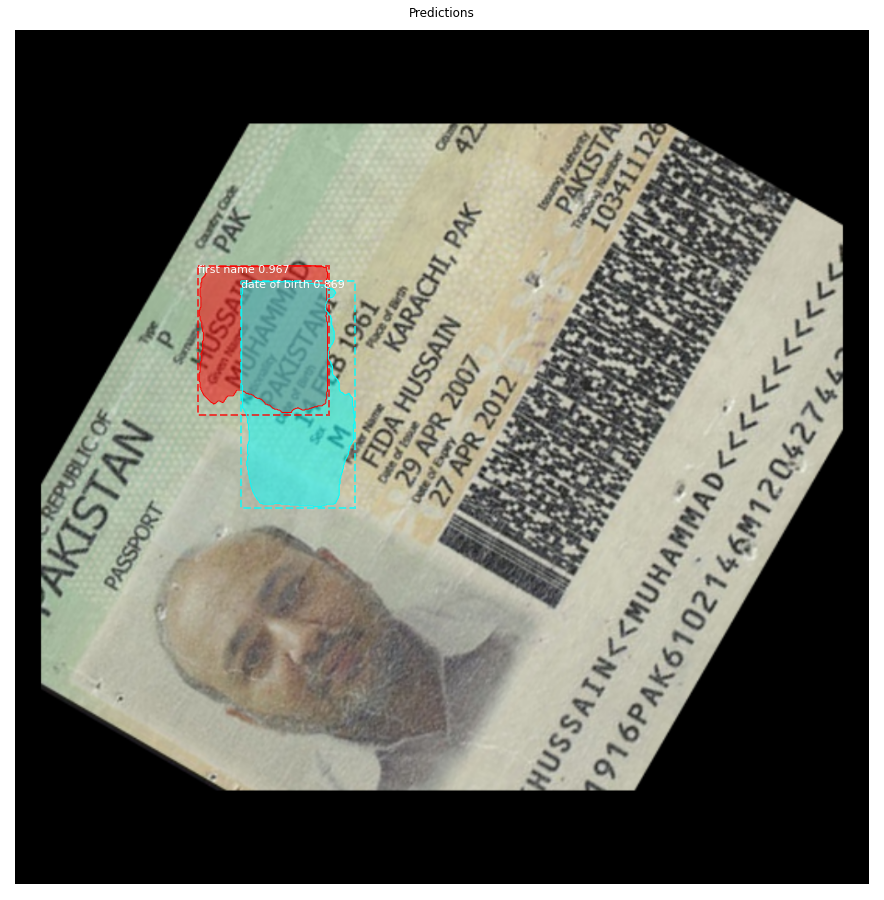

{'id': 'pass19_rotation55', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass19_rotation55.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass19_rotation55.xml'}
image ID: dataset.pass19_rotation55 (508) /content/Test_Set/Pak_Passport/pass19_rotation55.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


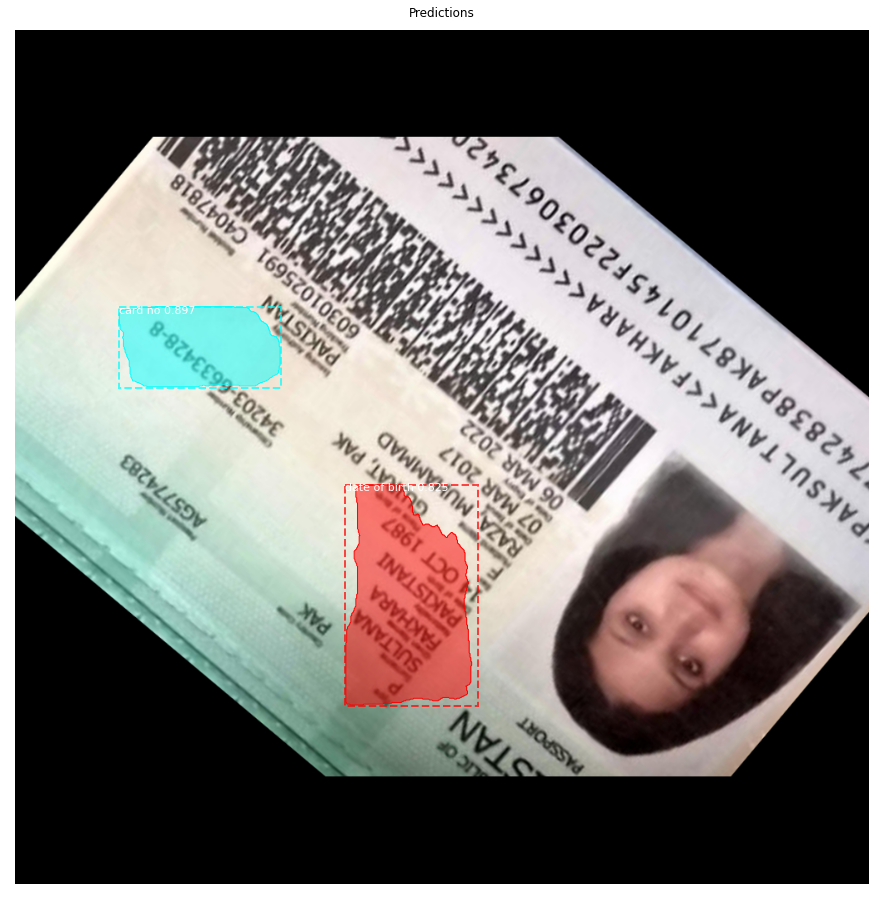

{'id': 'pass17_rotation1', 'source': 'dataset', 'path': '/content/Test_Set/Pak_Passport/pass17_rotation1.png', 'annotation': '/content/drive/MyDrive/Rotated_Passport/Rotated_XMLs/pass17_rotation1.xml'}
image ID: dataset.pass17_rotation1 (509) /content/Test_Set/Pak_Passport/pass17_rotation1.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


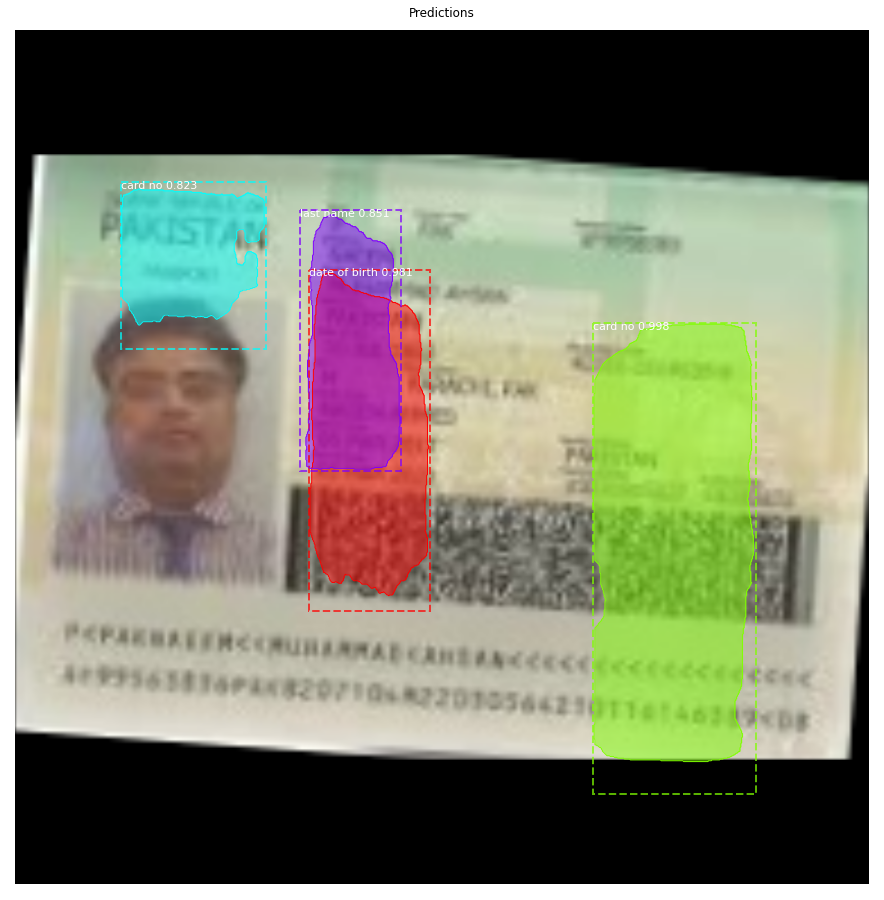

In [ ]:

for i in range(500, 510):
  image_id = i
  image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
  info = test_set.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                        test_set.image_reference(image_id)))
  # Run object detection
  results = model.detect([image], verbose=1)

  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              train_set.class_names, r['scores'], 
                              title="Predictions")